1. Loading Data and Preliminary Data Analyses 
2. Data Wrangling and Feature Engineering
3. Modeling and Feature Importance
4. Conclusion

In [1]:
# Import Libraries

import os
import sys
import warnings

import numpy as np 
import pandas as pd 
import seaborn as sns
import lightgbm as lgb
import scipy.stats as stats
import matplotlib.pyplot as plt

from math import sqrt
from datetime import datetime
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier import ROCAUC

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer

warnings.filterwarnings("ignore")

### Loading Data and Preliminary Data Analyses

In [2]:
# Load historical data 
data1=pd.read_csv('takehome_user_engagement.csv')

In [3]:
data1.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
data2 = pd.read_csv('takehome_users.csv',encoding='latin-1')

In [6]:
data2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [7]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


There are missing values for last_session_creation_time and invited_by_user_id features

### Data Wrangling and Feature Engineering

In [8]:
# change time_stamp feature from object to date time format
data1['time_stamp'] = pd.to_datetime(data1['time_stamp'])

# get days from the time_stamp feature
data1['time_stamp'] = data1['time_stamp'].dt.floor('d').astype(np.int64)

# sort then remove duplicate days per user
data1 = data1.sort_values(['user_id', 'time_stamp']).drop_duplicates()

# group by three days rolling 
three_day = data1.groupby('user_id')['time_stamp'].rolling(window=3)

# calculate day difference
day_diff = pd.to_timedelta((three_day.max()-three_day.min())).dt.days 

# filter the day difference to be within one week (7 days)
result = day_diff[day_diff <= 7].index.get_level_values('user_id').tolist()

In [9]:
# get unique users from adopted users list
myset=set(result)

# create new feature for adopted users for data2 dataframe
data2['adopted_users']=False

# create mapping dictionary for unique active users from myset set
mapping={}

for i in myset:
    mapping[i] = True

# assign True or False values to adopted users using the mapping dictionary
for i in range(len(data2['adopted_users'])):
    if data2['object_id'].iloc[i] in mapping:
        data2['adopted_users'].iloc[i] = True

In [10]:
# fill missing last_session_creation_time with median value
data2['last_session_creation_time']=data2['last_session_creation_time'].fillna(data2['last_session_creation_time'].median())

# change it to int from float
data2['last_session_creation_time']=data2['last_session_creation_time'].astype(int)

# create new feature to get last_session_creation_time from timestamp to datetime format
data2['last_creation_time']=(data2['last_session_creation_time']).apply(lambda x: datetime.utcfromtimestamp(x))

# create new features for days of week and daily hours from newly created feature
data2['hours'] = data2['last_creation_time'].dt.hour
data2['week_day'] = data2['last_creation_time'].dt.weekday

# create new feature from categorical variables using hot-encoding method 
data2 = pd.concat([data2, pd.get_dummies(data2['creation_source'], prefix = 'source')], axis = 1)
data2 = pd.concat([data2, pd.get_dummies(data2['hours'], prefix = 'hrs')], axis = 1)
data2 = pd.concat([data2, pd.get_dummies(data2['week_day'], prefix = 'day')], axis = 1)

# drop unnecessary features
data2.drop(data2[['hours', 'week_day', 'creation_source', 'invited_by_user_id', 'last_creation_time', 'creation_time', 'name', 'email', 'object_id']], axis = 1, inplace = True)

# modify adopted_users feature from False, True (boolean) to be 0, 1 (binary)
data2['adopted_users']=(data2['adopted_users']).astype(int)

In [11]:
# check the adopted_users feature to find how many adopted and non adopted users it includes
adopted, non_adopted = data2['adopted_users'].value_counts()

info=['Non adopted users', 'Adopted users']
count=[adopted, non_adopted]

df_users=pd.DataFrame({'User Info': info, 'Count': count})

In [12]:
df_users

,Count,User Info
0,10344,Non adopted users
1,1656,Adopted users


We will use adopted_users feature as a target for our model. We find that it is unbalanced, since there are more non adopted users then adopted ones. Thus, we will apply SMOTE oversampling technique to balance the target variable. 

### Modeling and Feature Importance

Accuracy of random forest classifier on test set: 0.91
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3103
           1       0.68      0.70      0.69       497

   micro avg       0.91      0.91      0.91      3600
   macro avg       0.82      0.83      0.82      3600
weighted avg       0.91      0.91      0.91      3600

Confusion Matrix:
[[2941  162]
 [ 148  349]]


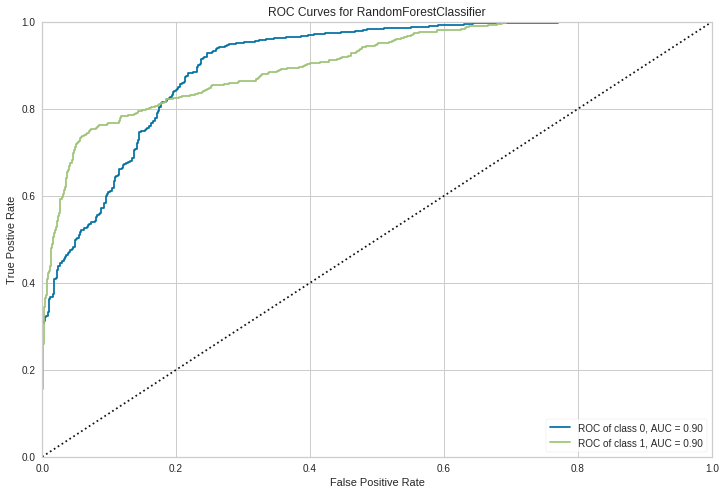

0.9183333333333333


In [13]:
# SMOTE oversampling + Random Forest classifier

X = np.array(data2.drop(['adopted_users'], 1))
y = np.array(data2['adopted_users'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

old_X_test = X_test
old_y_test = y_test

parameters = {'n_estimators':[200, 400, 600, 800, 1000], 'min_samples_leaf':[4, 8, 16], 'max_features': ['auto', 'sqrt']}
rfc = RandomForestClassifier(random_state=42, min_samples_split=5, oob_score=True)

sm = SMOTE(random_state=0, sampling_strategy=1.0, k_neighbors=7, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

rfc = RandomForestClassifier(random_state=42, criterion='entropy', min_samples_split=5, oob_score=True)
parameters = {'n_estimators':[200, 400, 600, 800, 1000], 'min_samples_leaf':[4, 8, 16], 'max_features': ['auto', 'sqrt']}

scoring = make_scorer(accuracy_score, greater_is_better=True)

cl_rand_fr = GridSearchCV(rfc, param_grid=parameters, cv=3, n_jobs=-1, scoring=scoring)
cl_rand_fr.fit(X_train_res, y_train_res)
cl_rand_fr = cl_rand_fr.best_estimator_

# Show prediction accuracy score
print ('Accuracy of random forest classifier on test set: {:.2f}'.format(accuracy_score(y_test, cl_rand_fr.predict(X_test))))
print ("Classification report:\n{}".format(classification_report(y_test,cl_rand_fr.predict(X_test))))
     
print("Confusion Matrix:\n{}".format(confusion_matrix(y_test, cl_rand_fr.predict(X_test))))
    
fig, ax=plt.subplots(1,1,figsize=(12,8))

auc=ROCAUC(cl_rand_fr, macro=False, micro=False)
auc.fit(X_train, y_train)
auc.score(X_test, y_test)
auc.poof()
                
precision,recall,fscore,support=score(y_test, cl_rand_fr.predict(X_test))
print (accuracy_score(y_test, cl_rand_fr.predict(X_test)))

In [14]:
df_columns = data2.drop('adopted_users', axis=1).columns.values

Text(0.5, 1.0, 'Feature Significance')

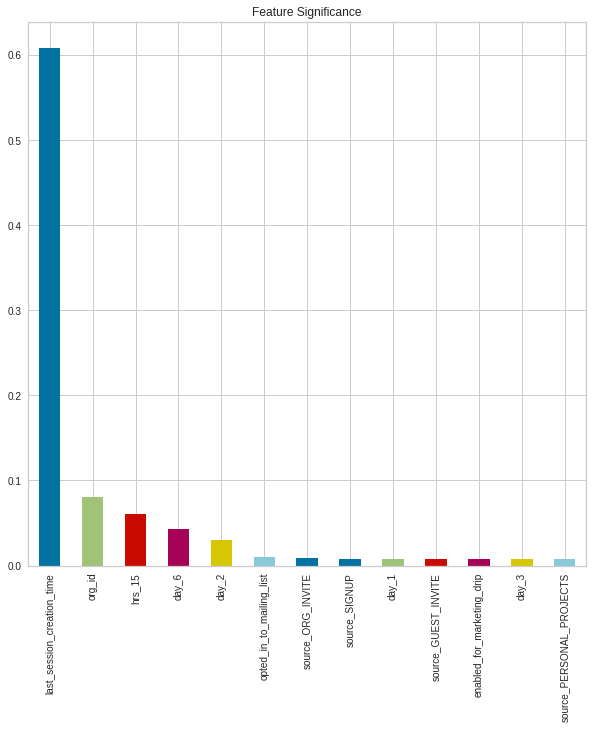

In [15]:
coef = pd.Series(cl_rand_fr.feature_importances_, index = df_columns).sort_values(ascending=False)

plt.figure(figsize=(10, 10))
coef.head(13).plot(kind='bar')
plt.title('Feature Significance')

The most important features are last_session_creation_time, org_id, hrs_15, day_6 and day_2.

### Conlusion

We analyzed two data sets and created new feature for adopted users. We performed data wrangling and cleaning. Also, we engineered new features, such as day and week day for modeling. Finally, we applied SMOTE oversampling rechnique and random forest classifier to predict on test set and find most important features in the dataset. Apparently, most important features in predicting adopted user were the last session was created, organization id, 15 hours feature and second and sixth days of a week features. 